# DO Amaïlys
# SOLAR Alexis
# M2A

 Copyright © Sorbonne University.

 This source code is licensed under the MIT license found in the
 LICENSE file in the root directory of this source tree.

# Outlook

In this notebook, using BBRL, you will study the effect of partial observability 
on the CartPoleContinuous-v1 environment, using either the DDPG or the TD3 algorithm.

To emulate partial observability, you will design dedicated wrappers. Then you will study
whether extending the input of the agent policy and critic with a memory of previous states
and its output with action chunks can help solve the partial observability issue. This will
also be achieved by designing other temporal extension wrappers.

# Installation

In [1]:
# Prepare the environment
try:
    from easypip import easyimport
except ModuleNotFoundError:
    from subprocess import run

    assert (
        run(["pip", "install", "easypip"]).returncode == 0
    ), "Could not install easypip"
    from easypip import easyimport

easyimport("swig")
easyimport("bbrl_utils").setup(maze_mdp=False)

import os
import copy
import numpy as np
import gymnasium as gym
import math
import bbrl_gymnasium  # noqa: F401
import torch
import torch.nn as nn
from torch.distributions import Normal
from bbrl.agents import Agent, Agents, TemporalAgent
from bbrl.agents.gymnasium import ParallelGymAgent, make_env
from bbrl_utils.algorithms import EpochBasedAlgo
from bbrl_utils.nn import build_mlp, setup_optimizer, soft_update_params
from bbrl_utils.notebook import setup_tensorboard
from bbrl.visu.plot_policies import plot_policy
from bbrl.stats import WelchTTest
from omegaconf import OmegaConf
from functools import partial

import matplotlib.pyplot as plt

c:\Users\asola\.conda\envs\deepdac\lib\site-packages\bbrl_utils\notebook.py:46: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # noqa: F401


# Temporal modification wrappers

The CartPoleContinuous-v1 environment is a custom extension of 
[the CartPole environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/) 
with continuous actions, between -1 and 1. It is defined in the bbrl_gymnasium library.

As in CartPole, the state of the system contains 4 variables:
- the position $x$,
- the velocity $\dot{x}$,
- the angle of the pole $\theta$,
- the angular velocity $\dot{\theta}$.

To emulate partial observability in CartPoleContinuous-v1, you will hide the $\dot{x}$ and $\dot{\theta}$ features, 
by filtering them out of the state of the environment. This is implemented with the ```FeatureFilterWrapper```.

To compensate for partial observability, you will extend the architecture of the agent 
with a memory of previous states and its output with action chunks.
This is implemented with to wrappers, the ```ObsTimeExtensionWrapper``` and the ```ActionTimeExtensionWrapper```.

## The FeatureFilterWrapper

The FeatureFilterWrapper removes a feature from the output observation when calling the ```reset()``` and ```step(action)``` functions.
The index of the removed feature is given when building the object.

To hide the $\dot{x}$ and $\dot{\theta}$ features from the CartPoleContinuous-v1 environment, 
the idea is to call the wrapper twice, using something like
```env = FeatureFilterWrapper(FeatureFilterWrapper(inner_env, 3), 1)``` where ```inner_env``` is the CartPoleContinuous-v1 environment.

### Exercise 1: code the FeatureFilterWrapper class below.

Beyond rewriting the ```reset()``` and ```step(action)``` functions, beware of adapting the observation space and its shape.

In [2]:
class FeatureFilterWrapper(gym.Wrapper):
    def __init__(self, env, index):
        super(FeatureFilterWrapper, self).__init__(env)
        self.index = index
        
        low = np.delete(self.env.observation_space.low, index)
        high = np.delete(self.env.observation_space.high, index)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.env.observation_space.dtype)
        
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        partial_obs = np.delete(obs, self.index)
        return partial_obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        partial_obs = np.delete(obs, self.index)
        return partial_obs, reward, terminated, truncated, info

## The ObsTimeExtensionWrapper

When facing a partially observable environment, training with RL a reactive agent which just selects an action based on the current observation
is not guaranteed to reach optimality. An option to mitigate this fundamental limitation is to equip the agent with a memory of the past.

One way to do so is to use a recurrent neural network instead of a feedforward one to implement the agent: the neural network contains
some memory capacity and the RL process may tune this internal memory so as to remember exactly what is necessary from the
past observation. This has been done many times using an LSTM, see for instance 
[this early paper](https://proceedings.neurips.cc/paper/2001/file/a38b16173474ba8b1a95bcbc30d3b8a5-Paper.pdf).

Another way to do so is to equip the agent with a list-like memory of the past observations 
and to extend the critic and policy to take as input the current observation and the previous ones.
This removes the difficulty of learning an adequate representation of the past, but this results in 
enlarging the input size of the actor and critic networks. This can only be done if the required memory
horizon to behave optimally is small enough.

In the case of the CartPoleContinuous-v1 environment, one can see immediately that a memory of the previous
observation is enough to compensate for the absence of the derivative features, since $\dot{a} \approx (a_{t} - a_{t-1})$.

So we will extend the RL agent with a memory of size 1.

Though it may not be intuitive at first glance, the simplest way to do so is to embed the environment into a wrapper
which contains the required memory and produces the extended observations. This way, the RL agent will naturally be built
with an extended observation space, and the wrapper will be in charge of concatenating the memorized
observation from the previous step with the current observation received from the inner environment when calling the ```step(action)``` function.
When calling the ```reset()``` function, the memory of observations should be reinitialized with null observations.

### Exercise 2: code the ObsTimeExtensionWrapper class below.

Beyond rewriting the ```reset()``` and ```step(action)``` functions, beware of adapting the observation space and its shape.

In [3]:
class ObsTimeExtensionWrapper(gym.Wrapper):
    def __init__(self, env):
        super(ObsTimeExtensionWrapper, self).__init__(env)
        
        original_obs_space = env.observation_space
        low = np.concatenate([original_obs_space.low, original_obs_space.low])
        high = np.concatenate([original_obs_space.high, original_obs_space.high])
        
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=original_obs_space.dtype)
        self.previous_obs = np.zeros(original_obs_space.shape, dtype=original_obs_space.dtype)

    def reset(self, **kwargs):
        current_obs, info = self.env.reset(**kwargs)
    
        self.previous_obs = np.zeros_like(current_obs)
        
        return np.concatenate([self.previous_obs, current_obs]), info
    
    def step(self, action):
        current_obs, reward, terminated, truncated, info = self.env.step(action)
        
        extended_obs = np.concatenate([self.previous_obs, current_obs])
        
        self.previous_obs = current_obs
        
        return extended_obs, reward, terminated, truncated, info

## The ActionTimeExtensionWrapper

It has been observed that, in partially observable environments, preparing to play a sequence of actions and only playing
the first can be better than only preparing for one action. The difference comes from the fact that the critic evaluates
sequences of actions, even if only the first is played in practice.

Similarly to the ObsTimeExtensionWrapper, the corresponding behavior can be implemented with a wrapper.
The size of the action space of the extended environment should be 
M times the size of the action space of the inner environment. This ensures that the policy and the critic
will consider extended actions.
Besides, the ```step(action)``` function should receive an extended actions of size M times the size of an action,
and should only transmit the first action to the inner environment.


### Exercise 3: code the ActionTimeExtensionWrapper class below.

Beyond rewriting the ```reset()``` and ```step(action)``` functions, beware of adapting the action space and its shape.

In [4]:
class ActionTimeExtensionWrapper(gym.Wrapper):
    def __init__(self, env, M):
        super(ActionTimeExtensionWrapper, self).__init__(env)
        self.M = M
        
        original_action_space = env.action_space
        low = np.tile(original_action_space.low, M)
        high = np.tile(original_action_space.high, M)
        self.action_space = gym.spaces.Box(low=low, high=high, dtype=original_action_space.dtype)

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    def step(self, extended_action):
        first_action = extended_action[:self.env.action_space.shape[0]]
        
        obs, reward, terminated, truncated, info = self.env.step(first_action)
        
        return obs, reward, terminated, truncated, info


## Launching tensorboard to visualize the results

In [35]:
setup_tensorboard("./outputs/tblogs")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2560), started 1:23:31 ago. (Use '!kill 2560' to kill it.)

# Experimental study

To run the experiments below, you can use the [DDPG](https://arxiv.org/pdf/1509.02971.pdf) 
or [TD3](http://proceedings.mlr.press/v80/fujimoto18a/fujimoto18a.pdf) algorithms.

You can just copy paste here the code you have used during the corresponding labs.
We only provide a suggested set of hyper-parameters working well on the CartPoleContinuous-v1 environment for DDPG.

In [5]:
class ContinuousQAgent(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        self.is_q_function = True
        self.model = build_mlp(
            [state_dim + action_dim] + list(hidden_layers) + [1], activation=nn.ReLU()
        )

    def forward(self, t):
        # Get the current state $s_t$ and the chosen action $a_t$
        obs = self.get(("env/env_obs", t))  # shape B x D_{obs}
        action = self.get(("action", t))  # shape B x D_{action}

        # Compute the Q-value(s_t, a_t)
        obs_act = torch.cat((obs, action), dim=1)  # shape B x (D_{obs} + D_{action})
        # Get the q-value (and remove the last dimension since it is a scalar)
        q_value = self.model(obs_act).squeeze(-1)
        self.set((f"{self.prefix}q_value", t), q_value)
        
class ContinuousDeterministicActor(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        layers = [state_dim] + list(hidden_layers) + [action_dim]
        self.model = build_mlp(
            layers, activation=nn.ReLU(), output_activation=nn.Tanh()
        )

    def forward(self, t, **kwargs):
        obs = self.get(("env/env_obs", t))
        action = self.model(obs)
        self.set(("action", t), action)
        
class AddGaussianNoise(Agent):
    def __init__(self, sigma):
        super().__init__()
        self.sigma = sigma

    def forward(self, t, **kwargs):
        act = self.get(("action", t))
        dist = Normal(act, self.sigma)
        action = dist.sample()
        self.set(("action", t), action)

mse = nn.MSELoss()    
def compute_critic_loss(cfg, reward: torch.Tensor, must_bootstrap: torch.Tensor, q_values: torch.Tensor, target_q_values: torch.Tensor):
    """Compute the DDPG critic loss from a sample of transitions

    :param cfg: The configuration
    :param reward: The reward (shape 2xB)
    :param must_bootstrap: Must bootstrap flag (shape 2xB)
    :param q_values: The computed Q-values (shape 2xB)
    :param target_q_values: The Q-values computed by the target critic (shape 2xB)
    :return: the loss (a scalar)
    """
    # Compute temporal difference
    # To be completed...

    # Apply the must_bootstrap flag to only propagate the Q-values where needed
    target = reward[1] + cfg.algorithm.discount_factor * target_q_values[1] * must_bootstrap[1].float()

    # Get the predicted Q-values for the actions actually taken in the current step
    qvals = q_values[0]

    critic_loss = mse(qvals, target)


    return critic_loss

def compute_actor_loss(q_values):
    """Returns the actor loss

    :param q_values: The q-values (shape 2xB)
    :return: A scalar (the loss)
    """
    # To be completed...

    return torch.mean(-q_values[0])

class DDPG(EpochBasedAlgo):
    def __init__(self, cfg):
        super().__init__(cfg)

        # we create the critic and the actor, but also an exploration agent to
        # add noise and a target critic. The version below does not use a target
        # actor as it proved hard to tune, but such a target actor is used in
        # the original paper.

        obs_size, act_size = self.train_env.get_obs_and_actions_sizes()
        self.critic = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic/")
        self.target_critic = copy.deepcopy(self.critic).with_prefix("target-critic/")

        self.actor = ContinuousDeterministicActor(
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )

        # As an alternative, you can use `AddOUNoise`
        noise_agent = AddGaussianNoise(cfg.algorithm.action_noise)

        self.train_policy = Agents(self.actor, noise_agent)
        self.eval_policy = self.actor

        # Define agents over time
        self.t_actor = TemporalAgent(self.actor)
        self.t_critic = TemporalAgent(self.critic)
        self.t_target_critic = TemporalAgent(self.target_critic)

        # Configure the optimizer
        self.actor_optimizer = setup_optimizer(cfg.actor_optimizer, self.actor)
        self.critic_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic)
        
def run_ddpg(ddpg: DDPG):
    for rb in ddpg.iter_replay_buffers():
        rb_workspace = rb.get_shuffled(ddpg.cfg.algorithm.batch_size)

        # Compute the critic loss
        ddpg.critic(rb_workspace, t=0)
        ddpg.actor(rb_workspace, t=1)
        ddpg.target_critic(rb_workspace,t=1)
        # Critic update
        # Compute critic loss


        q_values, terminated, reward, target_q_values = rb_workspace[
                "critic/q_value", "env/terminated", "env/reward", "target-critic/q_value"]
        must_bootstrap = ~terminated
        critic_loss = compute_critic_loss(ddpg.cfg, reward, must_bootstrap, q_values, target_q_values)



        # Gradient step (critic)
        ddpg.logger.add_log("critic_loss", critic_loss, ddpg.nb_steps)
        ddpg.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            ddpg.critic.parameters(), ddpg.cfg.algorithm.max_grad_norm
        )
        ddpg.critic_optimizer.step()

        # Compute the actor loss
        ddpg.actor(rb_workspace, t=0)
        ddpg.critic(rb_workspace,t=0)
        q_values = rb_workspace["critic/q_value"]
        actor_loss = compute_actor_loss(q_values)


        # Gradient step (actor)
        ddpg.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            ddpg.actor.parameters(), ddpg.cfg.algorithm.max_grad_norm
        )
        ddpg.actor_optimizer.step()

        # Soft update of target q function
        soft_update_params(
            ddpg.critic, ddpg.target_critic, ddpg.cfg.algorithm.tau_target
        )

        # Evaluate the actor if needed
        if ddpg.evaluate():
            if ddpg.cfg.plot_agents:
                plot_policy(
                    ddpg.actor,
                    ddpg.eval_env,
                    ddpg.best_reward,
                    str(ddpg.base_dir / "plots"),
                    ddpg.cfg.gym_env.env_name,
                    stochastic=False,
                )
        
class TD3(EpochBasedAlgo):
    def __init__(self, cfg):
        super().__init__(cfg)
        
        # Define the agents and optimizers for TD3
        obs_size, act_size = self.train_env.get_obs_and_actions_sizes()
        self.critic_1 = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic_1/")
        self.target_critic_1 = copy.deepcopy(self.critic_1).with_prefix("target-critic_1/")
        
        self.critic_2 = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic_2/")
        self.target_critic_2 = copy.deepcopy(self.critic_2).with_prefix("target-critic_2/")

        self.actor = ContinuousDeterministicActor(
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )
        
        noise_agent = AddGaussianNoise(cfg.algorithm.action_noise)
        self.train_policy = Agents(self.actor, noise_agent)
        self.eval_policy = self.actor
        
        # Define agents over time
        self.t_actor = TemporalAgent(self.actor)
        self.t_critic_1 = TemporalAgent(self.critic_1)
        self.t_target_critic_1 = TemporalAgent(self.target_critic_1)
        self.t_critic_2 = TemporalAgent(self.critic_2)
        self.t_target_critic_2 = TemporalAgent(self.target_critic_2)
        
        # Configure the optimizer
        self.actor_optimizer = setup_optimizer(cfg.actor_optimizer, self.actor)
        self.critic_1_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic_1)
        self.critic_2_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic_2)
        
def run_td3(td3: TD3):
    for rb in td3.iter_replay_buffers():
        rb_workspace = rb.get_shuffled(td3.cfg.algorithm.batch_size)

        # Implement the learning loop

        td3.critic_1(rb_workspace, t=0)
        td3.critic_2(rb_workspace, t=0)
        td3.actor(rb_workspace, t=1)
        td3.target_critic_1(rb_workspace,t=1)
        td3.target_critic_2(rb_workspace,t=1)
        
        q_values_1, q_values_2, terminated, reward, target_q_values_1, target_q_values_2 = rb_workspace[
                "critic_1/q_value", "critic_2/q_value", "env/terminated", "env/reward", "target-critic_1/q_value", "target-critic_2/q_value"]
        
        must_bootstrap = ~terminated
        
        # target_q_values: The Q-values computed by the target critic (shape 2xB)
        target_q_values = torch.min(target_q_values_1, target_q_values_2)
        
        critic_loss_1 = compute_critic_loss(td3.cfg, reward, must_bootstrap, q_values_1, target_q_values)
        critic_loss_2 = compute_critic_loss(td3.cfg, reward, must_bootstrap, q_values_2, target_q_values)
        
        # Gradient step (critic_1)
        td3.logger.add_log("critic_loss_1", critic_loss_1, td3.nb_steps)
        td3.critic_1_optimizer.zero_grad()
        critic_loss_1.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(
            td3.critic_1.parameters(), td3.cfg.algorithm.max_grad_norm
        )
        td3.critic_1_optimizer.step()
        
        # Gradient step (critic_2)
        td3.logger.add_log("critic_loss_2", critic_loss_2, td3.nb_steps)
        td3.critic_2_optimizer.zero_grad()
        critic_loss_2.backward()
        torch.nn.utils.clip_grad_norm_(
            td3.critic_2.parameters(), td3.cfg.algorithm.max_grad_norm
        )
        td3.critic_2_optimizer.step()
        
        # Compute the actor loss
        td3.actor(rb_workspace, t=0)
        td3.critic_1(rb_workspace,t=0)
        q_values = rb_workspace["critic_1/q_value"]
        actor_loss = compute_actor_loss(q_values)
        
        # Gradient step (actor)
        td3.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            td3.actor.parameters(), td3.cfg.algorithm.max_grad_norm
        )
        td3.actor_optimizer.step()
        
        # Soft update of target q function
        soft_update_params(
            td3.critic_1, td3.target_critic_1, td3.cfg.algorithm.tau_target
        )
        soft_update_params(
            td3.critic_2, td3.target_critic_2, td3.cfg.algorithm.tau_target
        )
        
        # Evaluate the actor if needed
        if td3.evaluate():
            if td3.cfg.plot_agents:
                plot_policy(
                    td3.actor,
                    td3.eval_env,
                    td3.best_reward,
                    str(td3.base_dir / "plots"),
                    td3.cfg.gym_env.env_name,
                    stochastic=False,
                )

## Definition of the parameters

The logger is defined as `bbrl.utils.logger.TFLogger` so as to use a
tensorboard visualisation.

In [6]:
params = {
    "save_best": False,
    "base_dir": "${gym_env.env_name}/TD3-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    # Set to true to have an insight on the learned policy
    # (but slows down the evaluation a lot!)
    "plot_agents": True,
    "algorithm": {
        "seed": 2,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 1,
        "n_steps": 100,
        "nb_evals": 10,
        "discount_factor": 0.8,
        "buffer_size": 1e6,
        "batch_size": 64,
        "tau_target": 0.05,
        "eval_interval": 2_000,
        "max_epochs": 1500,
        # Minimum number of transitions before learning starts
        "learning_starts": 10_000,
        "action_noise": 0.1,
        "architecture": {
            "actor_hidden_size": [400, 300],
            "critic_hidden_size": [400, 300],
        },
    },
    "gym_env": {
        "env_name": "CartPoleContinuous-v1",
    },
    "actor_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
    "critic_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
}

### Exercise 4:

You know have all the elements to study the impact of removing features from the environment
on the training performance, and the impact of temporally extending the agent in mitigating 
partial observability, both with observation and with action extension.

In practice, you should produce the following learning curves:

- a learning curve of your algorithm on the standard CartPoleContinuous-v1 environment with full observability,
- two learning curves, one from removing $\dot{x}$ from CartPoleContinuous-v1 and the other from removing $\dot{\theta}$, 
- one learning curve from removing both $\dot{x}$ and $\dot{\theta}$, 
- the same four learning curves as above, but adding each of the temporal extension wrappers, separately or combined.

The way to combine these learning curves in different figures is open to you but should be carefully considered
depending on the conclusions you want to draw. Beware of drawing conclusions from insufficient statistics.

Discuss what you observe and conclude from this study.

In [22]:
ddpg = DDPG(OmegaConf.create(params))
run_ddpg(ddpg)
ddpg.visualize_best()

  0%|          | 0/2500 [00:00<?, ?it/s]

Video of best agent recorded in outputs\CartPoleContinuous-v1\ddpg-S2_20241012-152446\best_agent.mp4
Moviepy - Building video D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\ddpg-S2_20241012-152446\best_agent.mp4.
Moviepy - Writing video D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\ddpg-S2_20241012-152446\best_agent.mp4



Moviepy - Done !
Moviepy - video ready D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\ddpg-S2_20241012-152446\best_agent.mp4


In [24]:
td3 = TD3(OmegaConf.create(params))
run_td3(td3)
td3.visualize_best()

  0%|          | 0/2500 [00:00<?, ?it/s]

Video of best agent recorded in outputs\CartPoleContinuous-v1\TD3-S2_20241012-152724\best_agent.mp4
Moviepy - Building video D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241012-152724\best_agent.mp4.
Moviepy - Writing video D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241012-152724\best_agent.mp4



Moviepy - Done !
Moviepy - video ready D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241012-152724\best_agent.mp4


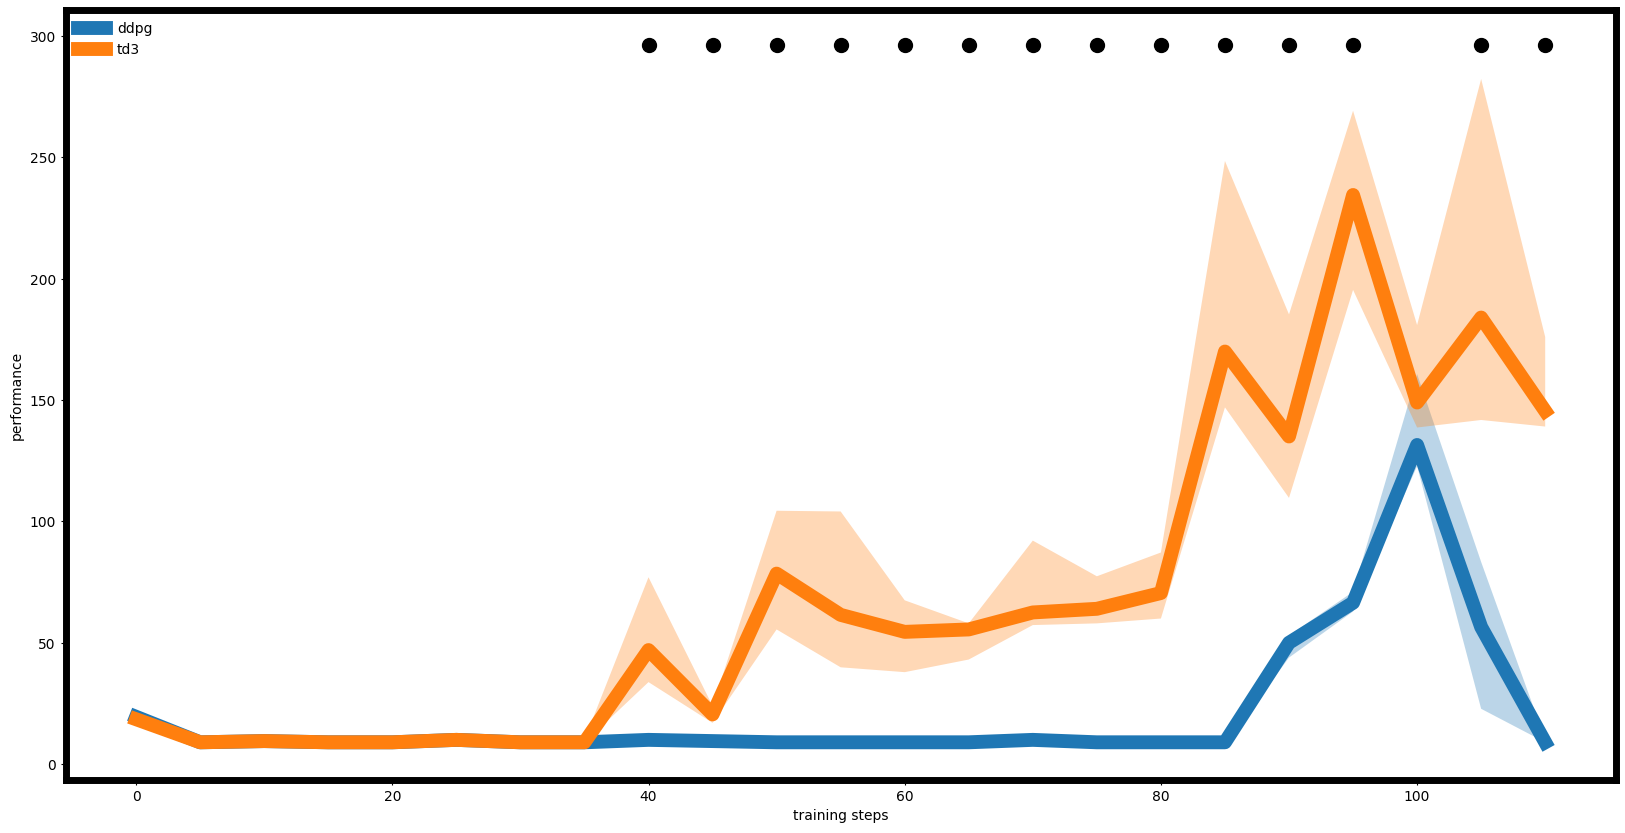

In [25]:
WelchTTest().plot(
    torch.stack(ddpg.eval_rewards),
    torch.stack(td3.eval_rewards),
    legends="ddpg/td3",
    save=False,
)

# On retire l'observation de la vélocité

In [8]:
class TD3(EpochBasedAlgo):
    def __init__(self, cfg):
        
        env_wrappers = [
            # retirer les velocity et angle de l'observation
            lambda env: FeatureFilterWrapper(env, 1)
        ]
        
        super().__init__(cfg, env_wrappers=env_wrappers)
        # Define the agents and optimizers for TD3
        obs_size, act_size = self.train_env.get_obs_and_actions_sizes()
        self.critic_1 = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic_1/")
        self.target_critic_1 = copy.deepcopy(self.critic_1).with_prefix("target-critic_1/")
        
        self.critic_2 = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic_2/")
        self.target_critic_2 = copy.deepcopy(self.critic_2).with_prefix("target-critic_2/")

        self.actor = ContinuousDeterministicActor(
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )
        
        noise_agent = AddGaussianNoise(cfg.algorithm.action_noise)
        self.train_policy = Agents(self.actor, noise_agent)
        self.eval_policy = self.actor
        
        # Define agents over time
        self.t_actor = TemporalAgent(self.actor)
        self.t_critic_1 = TemporalAgent(self.critic_1)
        self.t_target_critic_1 = TemporalAgent(self.target_critic_1)
        self.t_critic_2 = TemporalAgent(self.critic_2)
        self.t_target_critic_2 = TemporalAgent(self.target_critic_2)
        
        # Configure the optimizer
        self.actor_optimizer = setup_optimizer(cfg.actor_optimizer, self.actor)
        self.critic_1_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic_1)
        self.critic_2_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic_2)

In [9]:
td3_2 = TD3(OmegaConf.create(params))
run_td3(td3_2)
td3_2.visualize_best()

Matplotlib backend: module://matplotlib_inline.backend_inline


  0%|          | 0/2500 [00:00<?, ?it/s]

Video of best agent recorded in outputs\CartPoleContinuous-v1\TD3-S2_20241013-114037\best_agent.mp4
Moviepy - Building video D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-114037\best_agent.mp4.
Moviepy - Writing video D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-114037\best_agent.mp4



Moviepy - Done !
Moviepy - video ready D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-114037\best_agent.mp4


In [10]:
class DDPG(EpochBasedAlgo):
    def __init__(self, cfg):
        env_wrappers = [
            # retirer les velocity et angle de l'observation
            lambda env: FeatureFilterWrapper(env, 1)
        ]
        
        super().__init__(cfg, env_wrappers=env_wrappers)

        # we create the critic and the actor, but also an exploration agent to
        # add noise and a target critic. The version below does not use a target
        # actor as it proved hard to tune, but such a target actor is used in
        # the original paper.

        obs_size, act_size = self.train_env.get_obs_and_actions_sizes()
        self.critic = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic/")
        self.target_critic = copy.deepcopy(self.critic).with_prefix("target-critic/")

        self.actor = ContinuousDeterministicActor(
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )

        # As an alternative, you can use `AddOUNoise`
        noise_agent = AddGaussianNoise(cfg.algorithm.action_noise)

        self.train_policy = Agents(self.actor, noise_agent)
        self.eval_policy = self.actor

        # Define agents over time
        self.t_actor = TemporalAgent(self.actor)
        self.t_critic = TemporalAgent(self.critic)
        self.t_target_critic = TemporalAgent(self.target_critic)

        # Configure the optimizer
        self.actor_optimizer = setup_optimizer(cfg.actor_optimizer, self.actor)
        self.critic_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic)

In [11]:
ddpg_2 = DDPG(OmegaConf.create(params))
run_ddpg(ddpg_2)
ddpg_2.visualize_best()

  0%|          | 0/2500 [00:00<?, ?it/s]

Video of best agent recorded in outputs\CartPoleContinuous-v1\TD3-S2_20241013-114430\best_agent.mp4
Moviepy - Building video D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-114430\best_agent.mp4.
Moviepy - Writing video D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-114430\best_agent.mp4



Moviepy - Done !
Moviepy - video ready D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-114430\best_agent.mp4


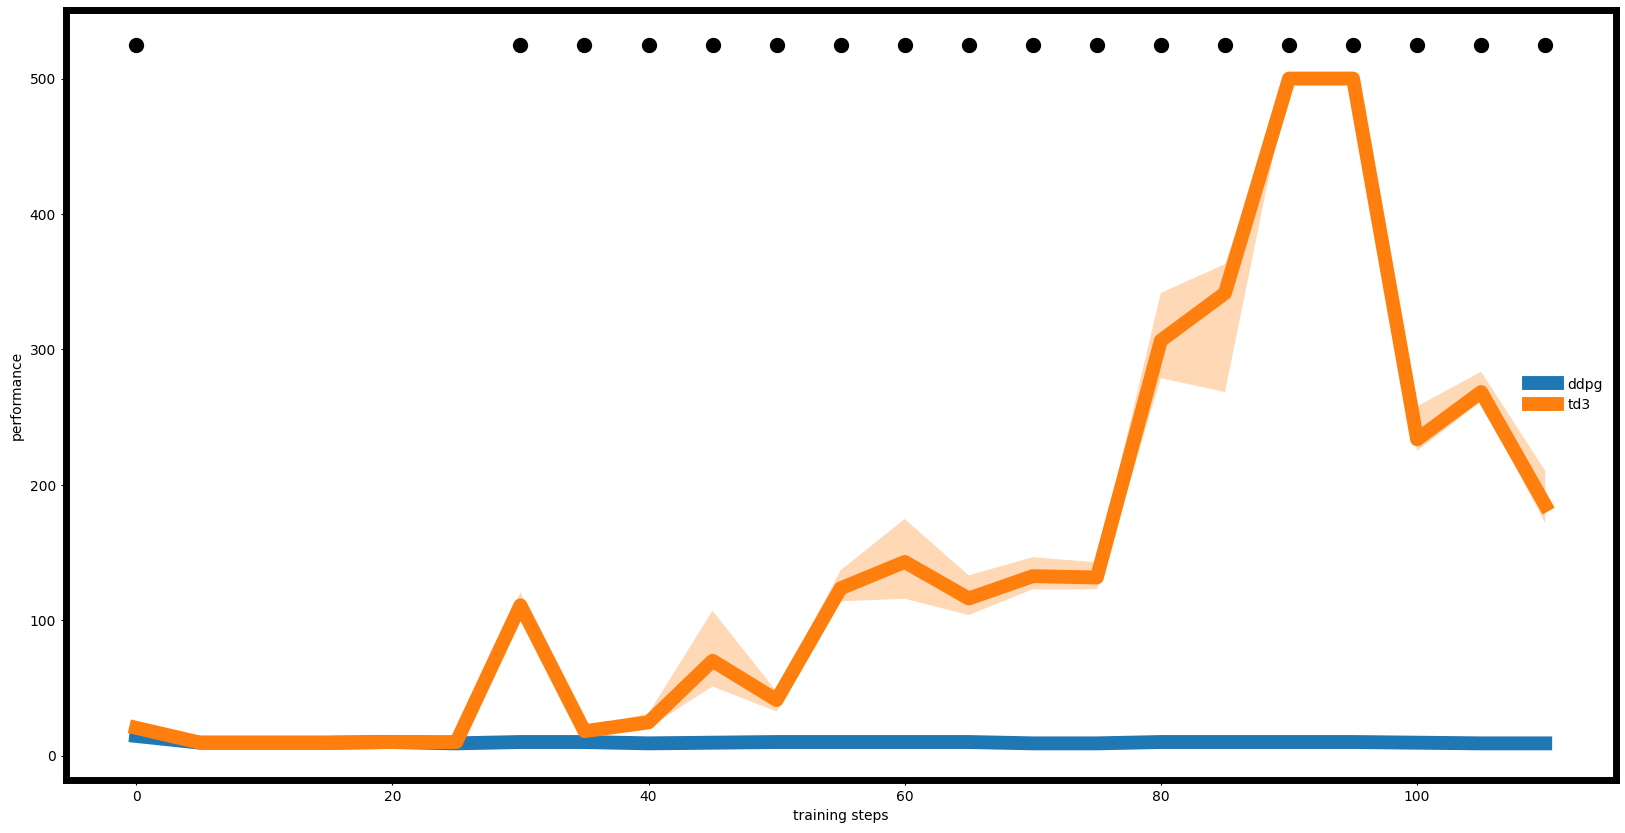

In [12]:
WelchTTest().plot(
    torch.stack(ddpg_2.eval_rewards),
    torch.stack(td3_2.eval_rewards),
    legends="ddpg/td3",
    save=False,
)

# On retire la vélocité angulaire

In [8]:
class TD3(EpochBasedAlgo):
    def __init__(self, cfg):
        
        env_wrappers = [
            # retirer les velocity et angle de l'observation
            lambda env: FeatureFilterWrapper(env, 3)
        ]
        
        super().__init__(cfg, env_wrappers=env_wrappers)
        # Define the agents and optimizers for TD3
        obs_size, act_size = self.train_env.get_obs_and_actions_sizes()
        self.critic_1 = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic_1/")
        self.target_critic_1 = copy.deepcopy(self.critic_1).with_prefix("target-critic_1/")
        
        self.critic_2 = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic_2/")
        self.target_critic_2 = copy.deepcopy(self.critic_2).with_prefix("target-critic_2/")

        self.actor = ContinuousDeterministicActor(
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )
        
        noise_agent = AddGaussianNoise(cfg.algorithm.action_noise)
        self.train_policy = Agents(self.actor, noise_agent)
        self.eval_policy = self.actor
        
        # Define agents over time
        self.t_actor = TemporalAgent(self.actor)
        self.t_critic_1 = TemporalAgent(self.critic_1)
        self.t_target_critic_1 = TemporalAgent(self.target_critic_1)
        self.t_critic_2 = TemporalAgent(self.critic_2)
        self.t_target_critic_2 = TemporalAgent(self.target_critic_2)
        
        # Configure the optimizer
        self.actor_optimizer = setup_optimizer(cfg.actor_optimizer, self.actor)
        self.critic_1_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic_1)
        self.critic_2_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic_2)

In [10]:
td3_3 = TD3(OmegaConf.create(params))
run_td3(td3_3)
td3_3.visualize_best()

  0%|          | 0/2500 [00:00<?, ?it/s]

Video of best agent recorded in outputs\CartPoleContinuous-v1\TD3-S2_20241013-160734\best_agent.mp4
Moviepy - Building video D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-160734\best_agent.mp4.
Moviepy - Writing video D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-160734\best_agent.mp4



Moviepy - Done !
Moviepy - video ready D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-160734\best_agent.mp4


In [11]:
class DDPG(EpochBasedAlgo):
    def __init__(self, cfg):
        env_wrappers = [
            # retirer les velocity et angle de l'observation
            lambda env: FeatureFilterWrapper(env, 3)
        ]
        
        super().__init__(cfg, env_wrappers=env_wrappers)

        # we create the critic and the actor, but also an exploration agent to
        # add noise and a target critic. The version below does not use a target
        # actor as it proved hard to tune, but such a target actor is used in
        # the original paper.

        obs_size, act_size = self.train_env.get_obs_and_actions_sizes()
        self.critic = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic/")
        self.target_critic = copy.deepcopy(self.critic).with_prefix("target-critic/")

        self.actor = ContinuousDeterministicActor(
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )

        # As an alternative, you can use `AddOUNoise`
        noise_agent = AddGaussianNoise(cfg.algorithm.action_noise)

        self.train_policy = Agents(self.actor, noise_agent)
        self.eval_policy = self.actor

        # Define agents over time
        self.t_actor = TemporalAgent(self.actor)
        self.t_critic = TemporalAgent(self.critic)
        self.t_target_critic = TemporalAgent(self.target_critic)

        # Configure the optimizer
        self.actor_optimizer = setup_optimizer(cfg.actor_optimizer, self.actor)
        self.critic_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic)

In [12]:
ddpg_3 = DDPG(OmegaConf.create(params))
run_ddpg(ddpg_3)
ddpg_3.visualize_best()

  0%|          | 0/2500 [00:00<?, ?it/s]

Video of best agent recorded in outputs\CartPoleContinuous-v1\TD3-S2_20241013-161131\best_agent.mp4
Moviepy - Building video D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-161131\best_agent.mp4.
Moviepy - Writing video D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-161131\best_agent.mp4



Moviepy - Done !
Moviepy - video ready D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-161131\best_agent.mp4


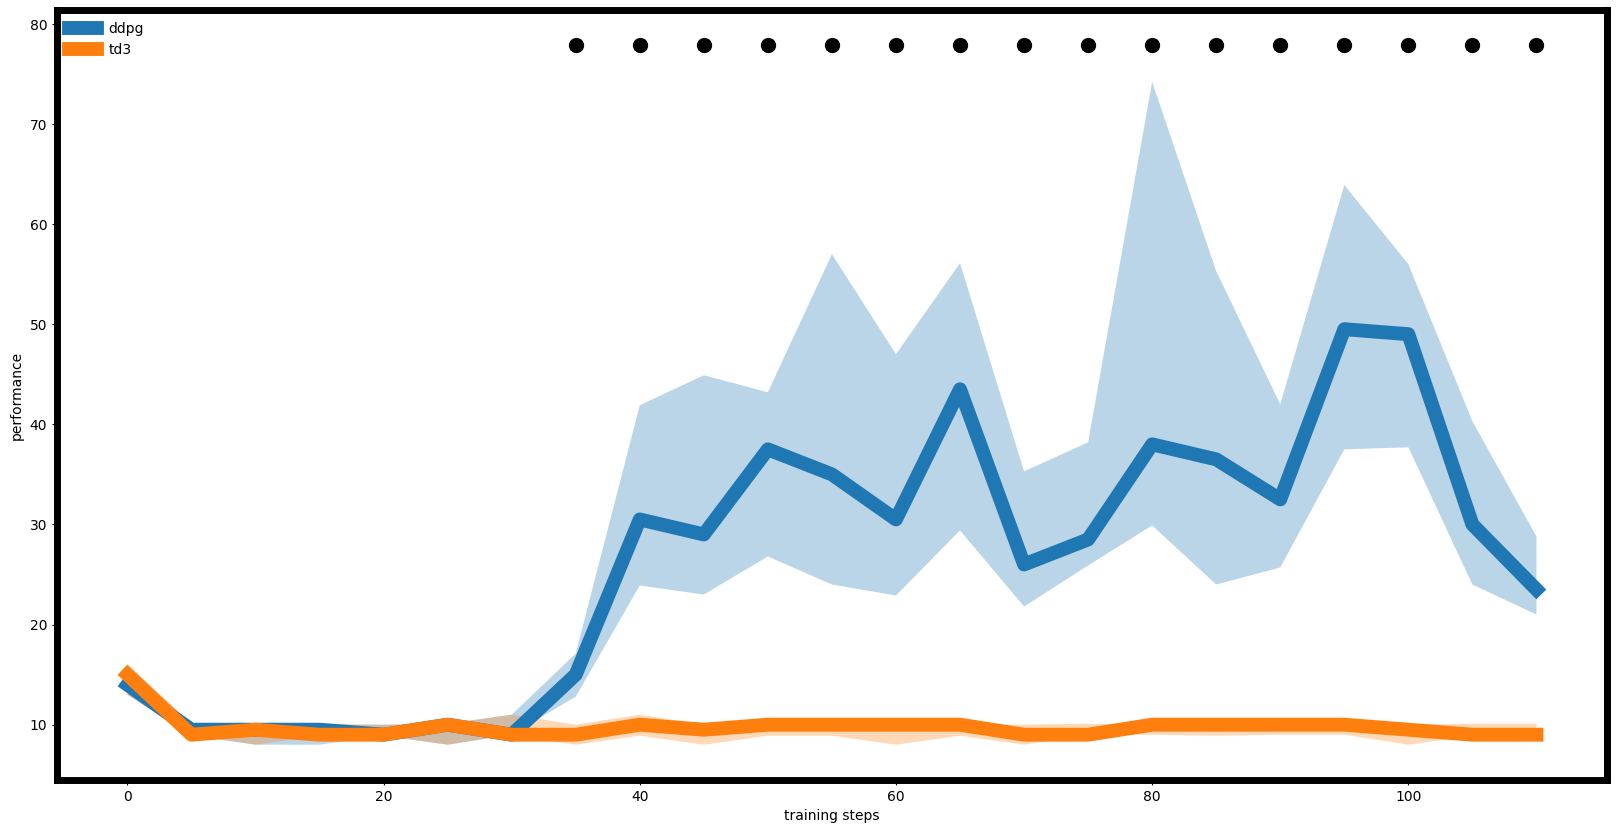

In [13]:
WelchTTest().plot(
    torch.stack(ddpg_3.eval_rewards),
    torch.stack(td3_3.eval_rewards),
    legends="ddpg/td3",
    save=False,
)

# On retire les 2

In [25]:
td3_4 = TD3(OmegaConf.create(params))
run_td3(td3_4)
td3_4.visualize_best()

  0%|          | 0/2500 [00:00<?, ?it/s]

Video of best agent recorded in outputs\CartPoleContinuous-v1\TD3-S2_20241013-163215\best_agent.mp4
Moviepy - Building video D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-163215\best_agent.mp4.
Moviepy - Writing video D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-163215\best_agent.mp4



Moviepy - Done !
Moviepy - video ready D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-163215\best_agent.mp4


In [19]:
class DDPG(EpochBasedAlgo):
    def __init__(self, cfg):
        env_wrappers = [
            # retirer les velocity et angle de l'observation
            lambda env: FeatureFilterWrapper(env, 3),
            lambda env: FeatureFilterWrapper(env, 1)
        ]
        
        super().__init__(cfg, env_wrappers=env_wrappers)

        # we create the critic and the actor, but also an exploration agent to
        # add noise and a target critic. The version below does not use a target
        # actor as it proved hard to tune, but such a target actor is used in
        # the original paper.

        obs_size, act_size = self.train_env.get_obs_and_actions_sizes()
        self.critic = ContinuousQAgent(
            obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
        ).with_prefix("critic/")
        self.target_critic = copy.deepcopy(self.critic).with_prefix("target-critic/")

        self.actor = ContinuousDeterministicActor(
            obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
        )

        # As an alternative, you can use `AddOUNoise`
        noise_agent = AddGaussianNoise(cfg.algorithm.action_noise)

        self.train_policy = Agents(self.actor, noise_agent)
        self.eval_policy = self.actor

        # Define agents over time
        self.t_actor = TemporalAgent(self.actor)
        self.t_critic = TemporalAgent(self.critic)
        self.t_target_critic = TemporalAgent(self.target_critic)

        # Configure the optimizer
        self.actor_optimizer = setup_optimizer(cfg.actor_optimizer, self.actor)
        self.critic_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic)

In [20]:
ddpg_4 = DDPG(OmegaConf.create(params))
run_ddpg(ddpg_4)
ddpg_4.visualize_best()

  0%|          | 0/2500 [00:00<?, ?it/s]

Video of best agent recorded in outputs\CartPoleContinuous-v1\TD3-S2_20241013-162705\best_agent.mp4
Moviepy - Building video D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-162705\best_agent.mp4.
Moviepy - Writing video D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-162705\best_agent.mp4



Moviepy - Done !
Moviepy - video ready D:\rld\mini_projet2\outputs\CartPoleContinuous-v1\TD3-S2_20241013-162705\best_agent.mp4


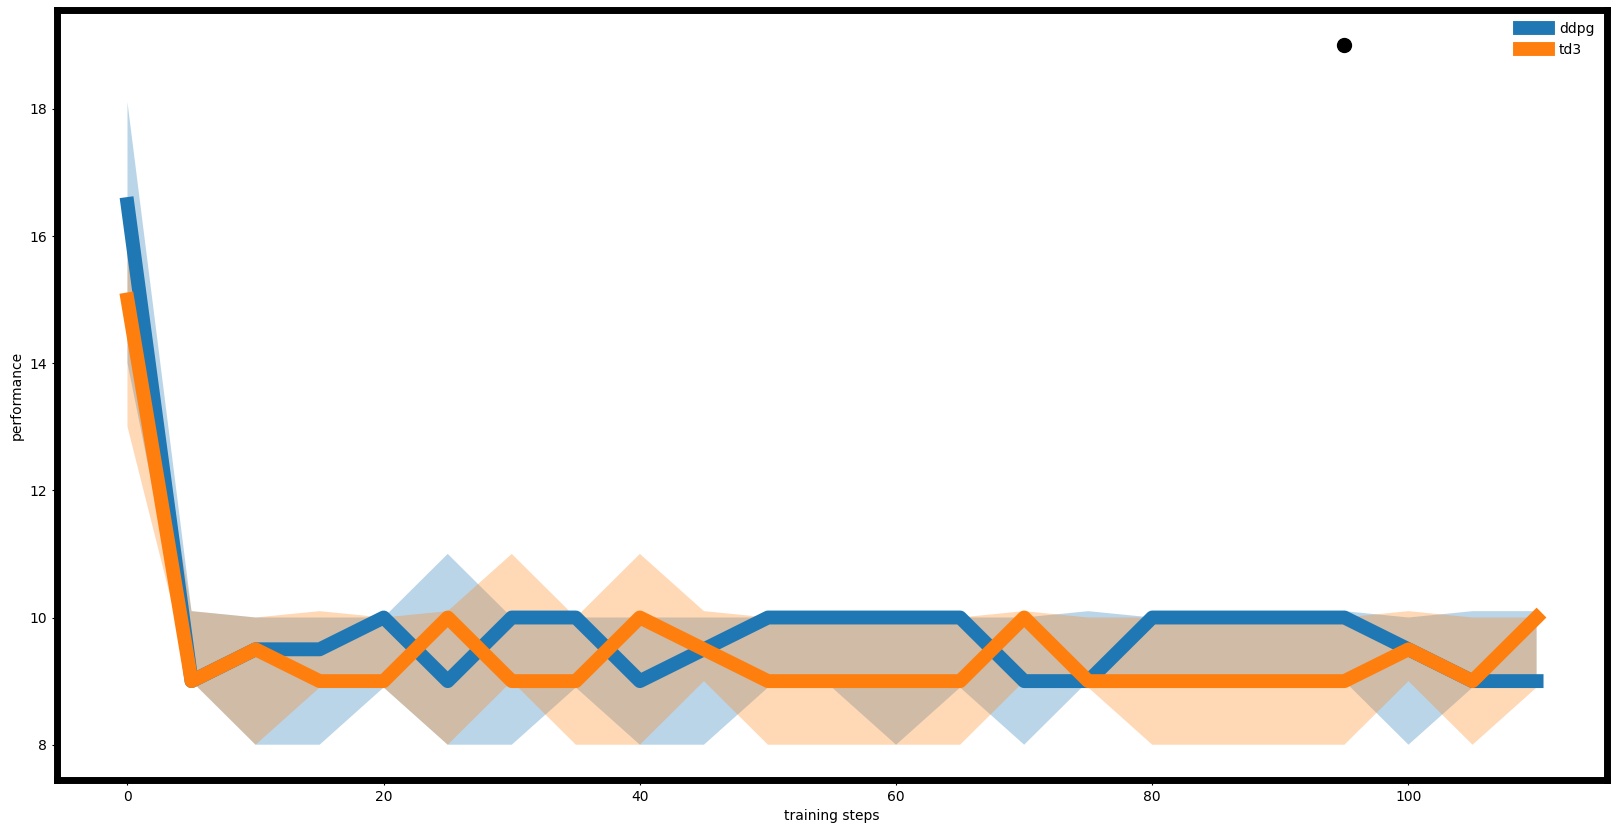

In [22]:
WelchTTest().plot(
    torch.stack(ddpg_4.eval_rewards),
    torch.stack(td3_4.eval_rewards),
    legends="ddpg/td3",
    save=False,
)

# tous les plots

# TD3

In [7]:
wrappers = [
    [[], 
     [lambda env: FeatureFilterWrapper(env, 1)], 
     [lambda env: FeatureFilterWrapper(env, 3)], 
     [lambda env: FeatureFilterWrapper(env, 3), lambda env: FeatureFilterWrapper(env, 1)]],

    [[lambda env: ObsTimeExtensionWrapper(env)], 
     [lambda env: FeatureFilterWrapper(env, 1), lambda env: ObsTimeExtensionWrapper(env)], 
     [lambda env: FeatureFilterWrapper(env, 3), lambda env: ObsTimeExtensionWrapper(env)], 
     [lambda env: FeatureFilterWrapper(env, 3), lambda env: FeatureFilterWrapper(env, 1), lambda env: ObsTimeExtensionWrapper(env)]],

    [[lambda env: ActionTimeExtensionWrapper(env, M=5)], 
     [lambda env: FeatureFilterWrapper(env, 1), lambda env: ActionTimeExtensionWrapper(env, M=5)], 
     [lambda env: FeatureFilterWrapper(env, 3), lambda env: ActionTimeExtensionWrapper(env, M=5)], 
     [lambda env: FeatureFilterWrapper(env, 3), lambda env: FeatureFilterWrapper(env, 1), lambda env: ActionTimeExtensionWrapper(env, M=5)]],

    [[lambda env: ActionTimeExtensionWrapper(env, M=5), lambda env: ObsTimeExtensionWrapper(env)], 
     [lambda env: FeatureFilterWrapper(env, 1), lambda env: ActionTimeExtensionWrapper(env, M=5), lambda env: ObsTimeExtensionWrapper(env)], 
     [lambda env: FeatureFilterWrapper(env, 3), lambda env: ActionTimeExtensionWrapper(env, M=5), lambda env: ObsTimeExtensionWrapper(env)], 
     [lambda env: FeatureFilterWrapper(env, 3), lambda env: FeatureFilterWrapper(env, 1), lambda env: ActionTimeExtensionWrapper(env, M=5), lambda env: ObsTimeExtensionWrapper(env)]]
]

params = {
    "save_best": False,
    "base_dir": "${gym_env.env_name}/TD3-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    # Set to true to have an insight on the learned policy
    # (but slows down the evaluation a lot!)
    "plot_agents": True,
    "algorithm": {
        "seed": 2,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 1,
        "n_steps": 100,
        "nb_evals": 10,
        "discount_factor": 0.8,
        "buffer_size": 1e6,
        "batch_size": 64,
        "tau_target": 0.05,
        "eval_interval": 2_000,
        "max_epochs": 3000,
        # Minimum number of transitions before learning starts
        "learning_starts": 10_000,
        "action_noise": 0.1,
        "architecture": {
            "actor_hidden_size": [400, 300],
            "critic_hidden_size": [400, 300],
        },
    },
    "gym_env": {
        "env_name": "CartPoleContinuous-v1",
    },
    "actor_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
    "critic_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
}

In [8]:
def F(wrapper, params):
    
    class TD3(EpochBasedAlgo):
        def __init__(self, cfg):
            
            super().__init__(cfg, env_wrappers=wrapper)
            # Define the agents and optimizers for TD3
            obs_size, act_size = self.train_env.get_obs_and_actions_sizes()
            self.critic_1 = ContinuousQAgent(
                obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
            ).with_prefix("critic_1/")
            self.target_critic_1 = copy.deepcopy(self.critic_1).with_prefix("target-critic_1/")
            
            self.critic_2 = ContinuousQAgent(
                obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
            ).with_prefix("critic_2/")
            self.target_critic_2 = copy.deepcopy(self.critic_2).with_prefix("target-critic_2/")

            self.actor = ContinuousDeterministicActor(
                obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
            )
            
            noise_agent = AddGaussianNoise(cfg.algorithm.action_noise)
            self.train_policy = Agents(self.actor, noise_agent)
            self.eval_policy = self.actor
            
            # Define agents over time
            self.t_actor = TemporalAgent(self.actor)
            self.t_critic_1 = TemporalAgent(self.critic_1)
            self.t_target_critic_1 = TemporalAgent(self.target_critic_1)
            self.t_critic_2 = TemporalAgent(self.critic_2)
            self.t_target_critic_2 = TemporalAgent(self.target_critic_2)
            
            # Configure the optimizer
            self.actor_optimizer = setup_optimizer(cfg.actor_optimizer, self.actor)
            self.critic_1_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic_1)
            self.critic_2_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic_2)
            
            
    td3 = TD3(OmegaConf.create(params))
    run_td3(td3)
    
    return td3.eval_rewards

def mean_rewards(wrapper, params, nbr=10):
    
    reward_list = []
    for i in range(nbr):
        params["algorithm"]["seed"] = i
        reward = torch.stack(F(wrapper, params))
        reward = torch.mean(reward, dim=1)
        reward_list.append(reward)
    
    return reward_list

def compute_rewards(wrappers, params):
    
    mean_reward_tensor = [[[] for _ in range(4)] for _ in range(4)]
    std_reward_tensor = [[[] for _ in range(4)] for _ in range(4)]
    
    for i in range(4):
        for j in range(4):
            
            reward = torch.stack(mean_rewards(wrappers[i][j], params))
    
            mean = torch.mean(reward, dim=0).tolist()
            std = torch.std(reward, dim=0).tolist()
            
            mean_reward_tensor[i][j] = mean
            std_reward_tensor[i][j] = std
    
    return np.array(mean_reward_tensor), np.array(std_reward_tensor)

In [9]:
def create_plot(mean_reward, std_reward):
    
    fig, axes = plt.subplots(4, 4, figsize=(18, 10))  # Taille ajustée pour une meilleure visualisation

    # Tracer les courbes sur chaque subplot
    for i in range(4):
        for j in range(4):
            ax = axes[i, j]  # Accéder au subplot (i, j)
            ax.plot(range(len(mean_reward[i,j])), mean_reward[i,j], label="TD3 Mean", color='red')  # Tracer la moyenne
            ax.fill_between(range(len(mean_reward[i,j])), mean_reward[i,j] - std_reward[i,j], mean_reward[i,j] + std_reward[i,j], color='red', alpha=0.2, label="TD3 standard deviation")
            #ax.plot(range(len(mean_reward2[i,j])), mean_reward2[i,j], label="DDPG Mean", color='blue')  # Tracer la moyenne
            #ax.fill_between(range(len(mean_reward2[i,j])), mean_reward2[i,j] - std_reward2[i,j], mean_reward2[i,j] + std_reward2[i,j], color='blue', alpha=0.2, label="DDPG standard deviation")
            ax.set_title(f"Plot {i*4 + j + 1}")  # Titre de chaque subplot
            ax.legend(fontsize='x-small')  # Ajouter une légende pour chaque subplot
            
            
            # Créer une nouvelle figure pour chaque subplot et copier son contenu
            fig_individual, ax_individual = plt.subplots()
            ax_individual.plot(range(len(mean_reward[i,j])), mean_reward[i,j], label="TD3 Mean", color='red')
            ax_individual.fill_between(range(len(mean_reward[i,j])), mean_reward[i,j] - std_reward[i,j], mean_reward[i,j] + std_reward[i,j], color='red', alpha=0.2, label="TD3 standard deviation")
            #ax_individual.plot(range(len(mean_reward2[i,j])), mean_reward2[i,j], label="DDPG Mean", color='blue')  # Tracer la moyenne
            #ax_individual.fill_between(range(len(mean_reward2[i,j])), mean_reward2[i,j] - std_reward2[i,j], mean_reward2[i,j] + std_reward2[i,j], color='blue', alpha=0.2, label="DDPG standard deviation")
            ax_individual.set_title(f"Plot {i*4 + j + 1}")
            ax_individual.legend()

            # Sauvegarder le subplot individuel
            fig_individual.savefig(f"subplot_{i}_{j}.png")
            plt.close(fig_individual)  # Fermer la figure pour libérer la mémoire
            
    # Ajuster l'espacement entre les subplots
    plt.tight_layout()

    fig.savefig("global_plot.png")

    # Afficher les plots
    plt.show()

Matplotlib backend: module://matplotlib_inline.backend_inline


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

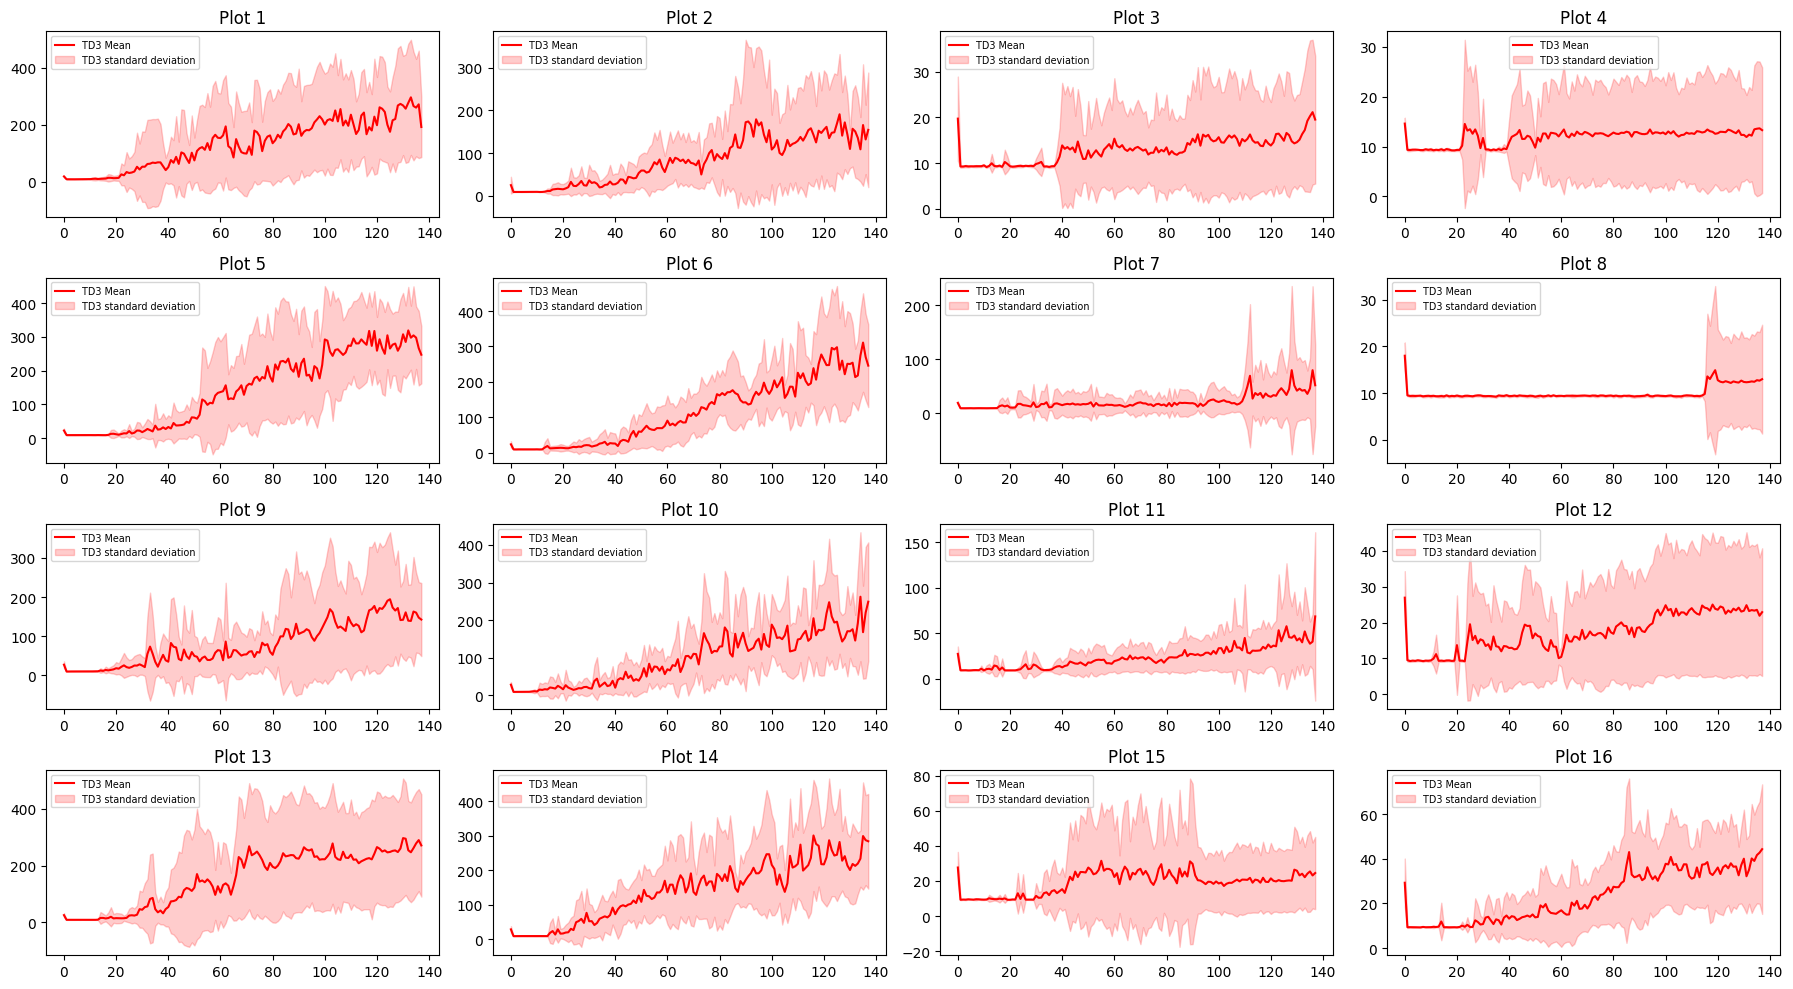

In [10]:
mean_reward, std_reward = compute_rewards(wrappers, params)

create_plot(mean_reward, std_reward)

# DDPG

In [10]:
wrappers = [
    [[], 
     [lambda env: FeatureFilterWrapper(env, 1)], 
     [lambda env: FeatureFilterWrapper(env, 3)], 
     [lambda env: FeatureFilterWrapper(env, 3), lambda env: FeatureFilterWrapper(env, 1)]],

    [[lambda env: ObsTimeExtensionWrapper(env)], 
     [lambda env: FeatureFilterWrapper(env, 1), lambda env: ObsTimeExtensionWrapper(env)], 
     [lambda env: FeatureFilterWrapper(env, 3), lambda env: ObsTimeExtensionWrapper(env)], 
     [lambda env: FeatureFilterWrapper(env, 3), lambda env: FeatureFilterWrapper(env, 1), lambda env: ObsTimeExtensionWrapper(env)]],

    [[lambda env: ActionTimeExtensionWrapper(env, M=5)], 
     [lambda env: FeatureFilterWrapper(env, 1), lambda env: ActionTimeExtensionWrapper(env, M=5)], 
     [lambda env: FeatureFilterWrapper(env, 3), lambda env: ActionTimeExtensionWrapper(env, M=5)], 
     [lambda env: FeatureFilterWrapper(env, 3), lambda env: FeatureFilterWrapper(env, 1), lambda env: ActionTimeExtensionWrapper(env, M=5)]],

    [[lambda env: ActionTimeExtensionWrapper(env, M=5), lambda env: ObsTimeExtensionWrapper(env)], 
     [lambda env: FeatureFilterWrapper(env, 1), lambda env: ActionTimeExtensionWrapper(env, M=5), lambda env: ObsTimeExtensionWrapper(env)], 
     [lambda env: FeatureFilterWrapper(env, 3), lambda env: ActionTimeExtensionWrapper(env, M=5), lambda env: ObsTimeExtensionWrapper(env)], 
     [lambda env: FeatureFilterWrapper(env, 3), lambda env: FeatureFilterWrapper(env, 1), lambda env: ActionTimeExtensionWrapper(env, M=5), lambda env: ObsTimeExtensionWrapper(env)]]
]

params = {
    "save_best": False,
    "base_dir": "${gym_env.env_name}/TD3-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    # Set to true to have an insight on the learned policy
    # (but slows down the evaluation a lot!)
    "plot_agents": True,
    "algorithm": {
        "seed": 2,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 1,
        "n_steps": 100,
        "nb_evals": 10,
        "discount_factor": 0.8,
        "buffer_size": 1e6,
        "batch_size": 64,
        "tau_target": 0.05,
        "eval_interval": 2_000,
        "max_epochs": 2500,
        # Minimum number of transitions before learning starts
        "learning_starts": 10_000,
        "action_noise": 0.1,
        "architecture": {
            "actor_hidden_size": [400, 300],
            "critic_hidden_size": [400, 300],
        },
    },
    "gym_env": {
        "env_name": "CartPoleContinuous-v1",
    },
    "actor_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
    "critic_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
        # "eps": 5e-5,
    },
}

def F2(wrapper, params):
    
    class DDPG(EpochBasedAlgo):
        def __init__(self, cfg):
            
            super().__init__(cfg, env_wrappers=wrapper)

            # we create the critic and the actor, but also an exploration agent to
            # add noise and a target critic. The version below does not use a target
            # actor as it proved hard to tune, but such a target actor is used in
            # the original paper.

            obs_size, act_size = self.train_env.get_obs_and_actions_sizes()
            self.critic = ContinuousQAgent(
                obs_size, cfg.algorithm.architecture.critic_hidden_size, act_size
            ).with_prefix("critic/")
            self.target_critic = copy.deepcopy(self.critic).with_prefix("target-critic/")

            self.actor = ContinuousDeterministicActor(
                obs_size, cfg.algorithm.architecture.actor_hidden_size, act_size
            )

            # As an alternative, you can use `AddOUNoise`
            noise_agent = AddGaussianNoise(cfg.algorithm.action_noise)

            self.train_policy = Agents(self.actor, noise_agent)
            self.eval_policy = self.actor

            # Define agents over time
            self.t_actor = TemporalAgent(self.actor)
            self.t_critic = TemporalAgent(self.critic)
            self.t_target_critic = TemporalAgent(self.target_critic)

            # Configure the optimizer
            self.actor_optimizer = setup_optimizer(cfg.actor_optimizer, self.actor)
            self.critic_optimizer = setup_optimizer(cfg.critic_optimizer, self.critic)
            
            
    ddpg = DDPG(OmegaConf.create(params))
    run_ddpg(ddpg)
    
    return ddpg.eval_rewards

def mean_rewards2(wrapper, params, nbr=10):
    
    reward_list = []
    for i in range(nbr):
        params["algorithm"]["seed"] = i
        reward = torch.stack(F2(wrapper, params))
        reward = torch.mean(reward, dim=1)
        reward_list.append(reward)
    
    return reward_list

def compute_rewards2(wrappers, params):
    
    mean_reward_tensor = [[[] for _ in range(4)] for _ in range(4)]
    std_reward_tensor = [[[] for _ in range(4)] for _ in range(4)]
    
    for i in range(4):
        for j in range(4):
            
            reward = torch.stack(mean_rewards2(wrappers[i][j], params))
    
            mean = torch.mean(reward, dim=0).tolist()
            std = torch.std(reward, dim=0).tolist()
            
            mean_reward_tensor[i][j] = mean
            std_reward_tensor[i][j] = std
    
    return np.array(mean_reward_tensor), np.array(std_reward_tensor)

def create_plot(mean_reward, std_reward):
    
    fig, axes = plt.subplots(4, 4, figsize=(18, 10))  # Taille ajustée pour une meilleure visualisation

    # Tracer les courbes sur chaque subplot
    for i in range(4):
        for j in range(4):
            ax = axes[i, j]  # Accéder au subplot (i, j)
            ax.plot(range(len(mean_reward[i,j])), mean_reward[i,j], label="DDPG Mean", color='blue')  # Tracer la moyenne
            ax.fill_between(range(len(mean_reward[i,j])), np.maximum(mean_reward[i,j] - std_reward[i,j],np.zeros(mean_reward[i,j].shape[0])), mean_reward[i,j] + std_reward[i,j], color='blue', alpha=0.2, label="DDPG standard deviation")
            #ax.plot(range(len(mean_reward2[i,j])), mean_reward2[i,j], label="DDPG Mean", color='blue')  # Tracer la moyenne
            #ax.fill_between(range(len(mean_reward2[i,j])), mean_reward2[i,j] - std_reward2[i,j], mean_reward2[i,j] + std_reward2[i,j], color='blue', alpha=0.2, label="DDPG standard deviation")
            ax.set_title(f"Plot {i*4 + j + 1}")  # Titre de chaque subplot
            ax.legend(fontsize='x-small')  # Ajouter une légende pour chaque subplot
            
            
            # Créer une nouvelle figure pour chaque subplot et copier son contenu
            fig_individual, ax_individual = plt.subplots()
            ax_individual.plot(range(len(mean_reward[i,j])), mean_reward[i,j], label="DDPG Mean", color='blue')
            ax_individual.fill_between(range(len(mean_reward[i,j])), np.maximum(mean_reward[i,j] - std_reward[i,j],np.zeros(mean_reward[i,j].shape[0])), mean_reward[i,j] + std_reward[i,j], color='blue', alpha=0.2, label="DDPG standard deviation")
            #ax_individual.plot(range(len(mean_reward2[i,j])), mean_reward2[i,j], label="DDPG Mean", color='blue')  # Tracer la moyenne
            #ax_individual.fill_between(range(len(mean_reward2[i,j])), mean_reward2[i,j] - std_reward2[i,j], mean_reward2[i,j] + std_reward2[i,j], color='blue', alpha=0.2, label="DDPG standard deviation")
            ax_individual.set_title(f"Plot {i*4 + j + 1}")
            ax_individual.legend()

            # Sauvegarder le subplot individuel
            fig_individual.savefig(f"subplotV3_{i}_{j}.png")
            plt.close(fig_individual)  # Fermer la figure pour libérer la mémoire
            
    # Ajuster l'espacement entre les subplots
    plt.tight_layout()

    fig.savefig("global_plotV3.png")

    # Afficher les plots
    plt.show()

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

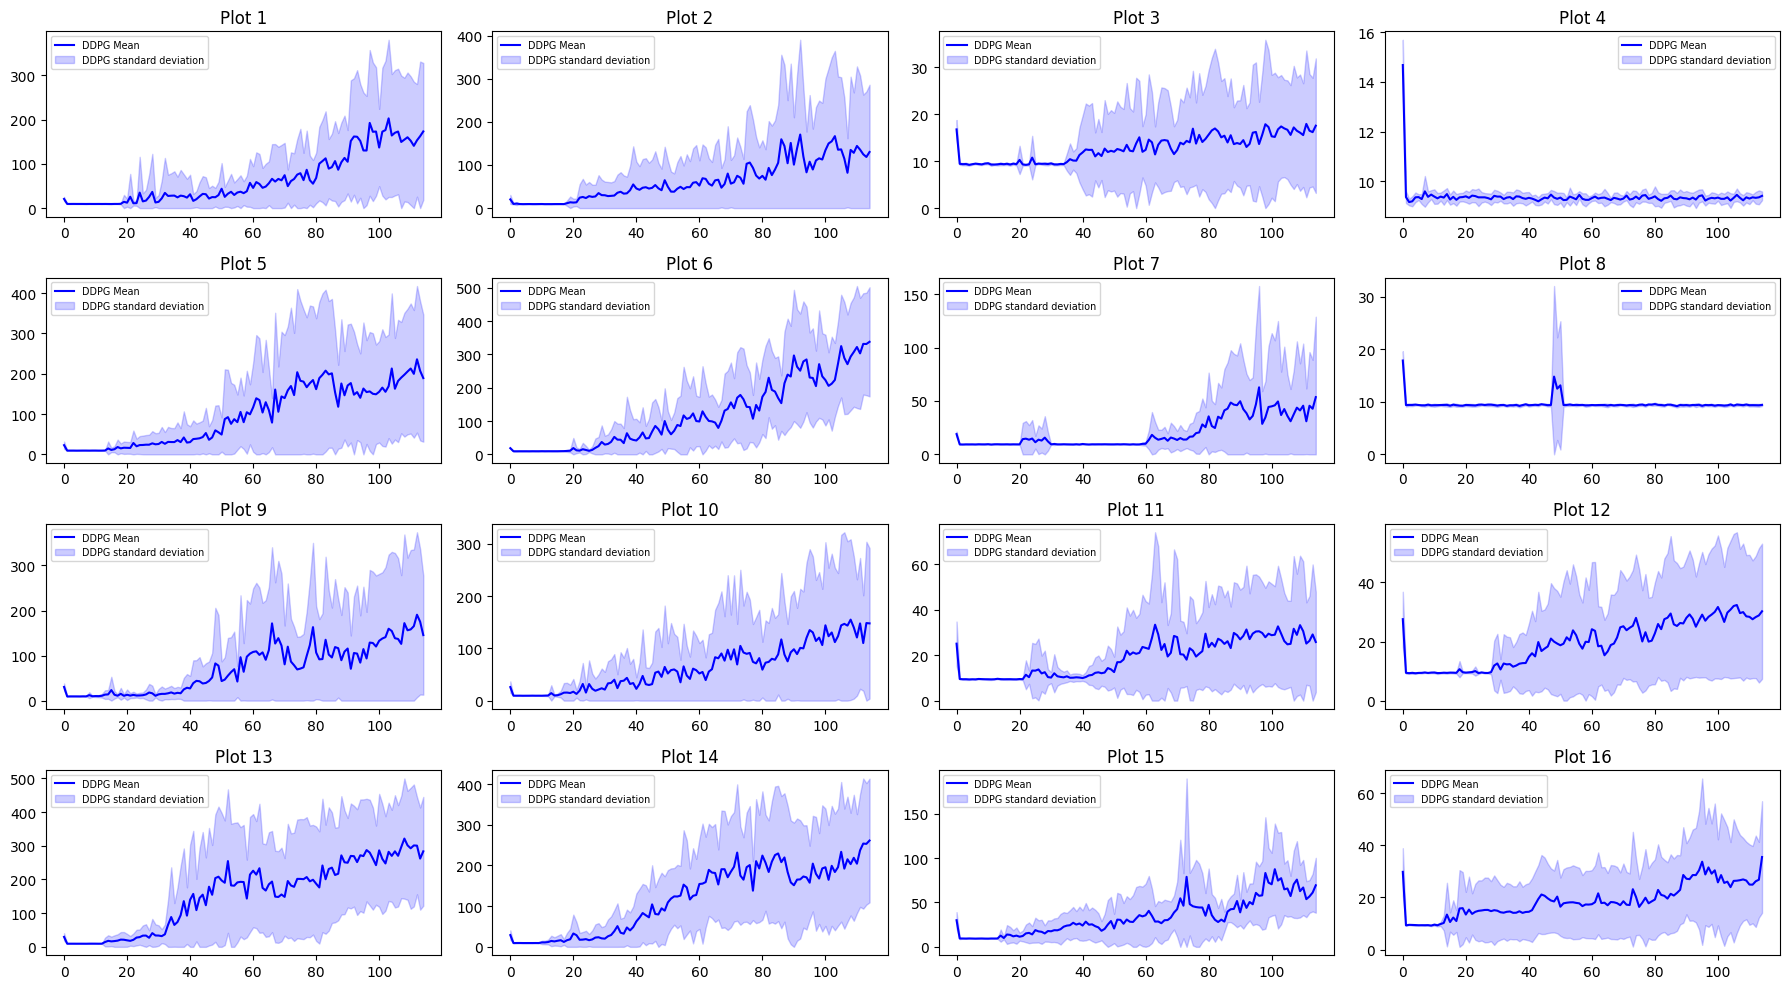

In [11]:
mean3, std3 = compute_rewards2(wrappers=wrappers, params=params)
create_plot(mean3, std3)

# Lab report

Your report should contain:
- your source code (probably this notebook), do not forget to put your names on top of the notebook,
- in a separate pdf file with your names in the name of the file:
    + a detailed enough description of all the choices you have made: the parameters you have set, the algorithms you have used, etc.,
    + the curves obtained when doing Exercise 3,
    + your conclusion from these experiments.

Beyond the elements required in this report, any additional studies will be rewarded.
For instance, you can extend the temporal horizon for the state memory and or action sequences beyond 2, and study the 
impact on learning performance and training time,
you can play with other partially observable environments, etc.
A great achievement would be to perform a comparison with the approach based on an LSTM.